In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd /content/drive/My Drive/Colab_Notebooks/

/content/drive/My Drive/Colab_Notebooks


In [ ]:
# mkdir dhaka-ai
% cd dhaka-ai

/content/drive/My Drive/Colab_Notebooks/dhaka-ai


In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !rm kaggle.json

In [ ]:
# !kaggle datasets download -d rifat963/dhakaai-dhaka-based-traffic-detection-dataset

In [ ]:
# from zipfile import ZipFile
# file_name="/content/drive/My Drive/Colab_Notebooks/dhaka-ai/dhakaai-dhaka-based-traffic-detection-dataset.zip"

# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('Done')

In [ ]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
%matplotlib inline

In [ ]:
PATH = os.path.abspath("/content/drive/My Drive/Colab_Notebooks/dhaka-ai/train/Final Train Dataset")
images_jpg = glob(os.path.join(PATH,"*.jpg"))
images_JPG = glob(os.path.join(PATH,"*.JPG"))
images_jpeg = glob(os.path.join(PATH,"*.jpeg"))
images_png = glob(os.path.join(PATH,"*.png"))
images_PNG = glob(os.path.join(PATH,"*.PNG"))
images=sorted(images_jpg+images_jpeg+images_png+images_JPG+images_PNG)

In [ ]:
xml_files=sorted(glob(os.path.join(PATH, "*.xml")))
# xml_files

In [ ]:
images.remove('/content/drive/My Drive/Colab_Notebooks/dhaka-ai/train/Final Train Dataset/231.jpg')
xml_files.remove('/content/drive/My Drive/Colab_Notebooks/dhaka-ai/train/Final Train Dataset/231.xml')

In [ ]:
x = [] # images as arrays

for img in images:
    # Read and resize image
    full_size_image = cv2.imread(img)
    x.append(cv2.resize(full_size_image, (1024, 1024), interpolation=cv2.INTER_CUBIC))


In [ ]:
#collecting images name
image_ids=[]
for image_id in images:
    ids=image_id.split('/')[8].split('.')[0]
    image_ids.append(ids)
image_ids[0:5]

['01', '02', '03', '04', '05']

In [ ]:
# Set it up as a dataframe
df = pd.DataFrame()
df["image_id"]=image_ids
df["images"]=x
df.head()

,image_id,images
0,01,"[[[37, 46, 50], [38, 47, 50], [38, 47, 50], [4..."
1,02,"[[[32, 30, 30], [28, 27, 24], [23, 24, 13], [3..."
2,03,"[[[253, 248, 255], [252, 248, 255], [254, 250,..."
3,04,"[[[143, 129, 127], [152, 137, 136], [165, 150,..."
4,05,"[[[123, 118, 109], [123, 118, 109], [122, 117,..."


In [ ]:
xml_df=pd.DataFrame(columns=['image_id','class','xmin','ymin','xmax','ymax'])
dictionary={}
for xml_dir in xml_files:
    
    tree = ET.parse(xml_dir)
    root = tree.getroot()

    i=xml_dir.split('/')[8].split('.')[0]
    sample_annotations = []
    for objects in root.iter('object'):
        vehicle=objects.find('name').text
    
    

        for neighbor in objects.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)
            
            
            if i in dictionary.keys():
                dictionary[i].append([vehicle,xmin, ymin, xmax, ymax])
                
            
            else:
                dictionary[i]=[[vehicle,xmin, ymin, xmax, ymax]]
        
        
        
        xml_df.loc[objects]=[i,vehicle,xmin, ymin, xmax, ymax]

In [ ]:
xml_df.head()

,image_id,class,xmin,ymin,xmax,ymax
"[[], [], [], [], [[], [], [], []]]",train,bus,833,390,1087,800
"[[], [], [], [], [[], [], [], []]]",train,bus,901,284,1018,395
"[[], [], [], [], [[], [], [], []]]",train,bus,909,241,1010,287
"[[], [], [], [], [[], [], [], []]]",train,rickshaw,761,413,832,540
"[[], [], [], [], [[], [], [], []]]",train,rickshaw,777,364,828,409


In [ ]:
classes=list(xml_df['class'].unique())
classes

['bus',
 'rickshaw',
 'motorbike',
 'car',
 'three wheelers (CNG)',
 'pickup',
 'minivan',
 'suv',
 'van',
 'taxi',
 'truck',
 'bicycle',
 'policecar',
 'ambulance',
 'human hauler',
 'wheelbarrow',
 'minibus',
 'auto rickshaw',
 'army vehicle',
 'scooter',
 'garbagevan']

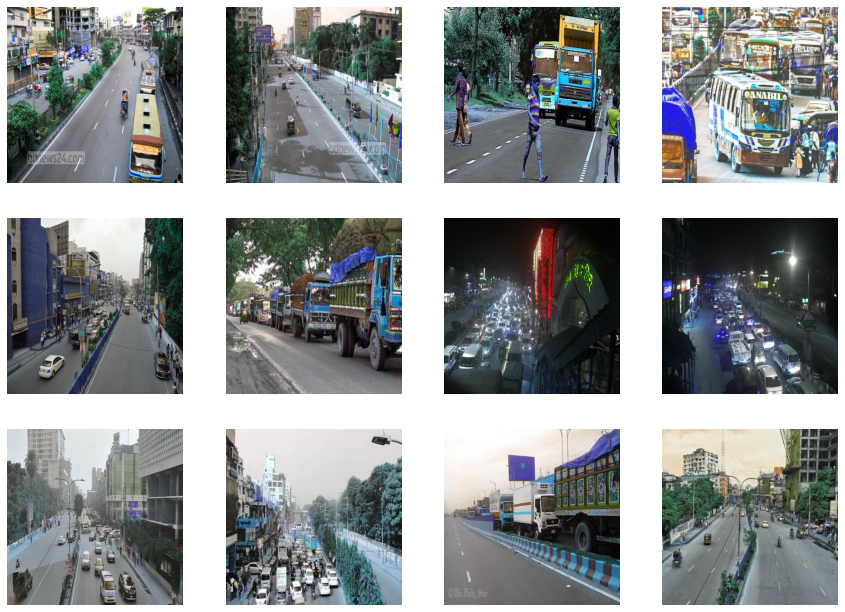

In [ ]:
#Display 12 train images
row = 3; col = 4;

plt.figure(figsize=(15,int(15*row/col)))

for j,img in enumerate(df['images'].loc[0:row*col-1]):
    
    plt.subplot(row,col,j+1)
    plt.axis('off')
    plt.imshow(img)
        
plt.show()

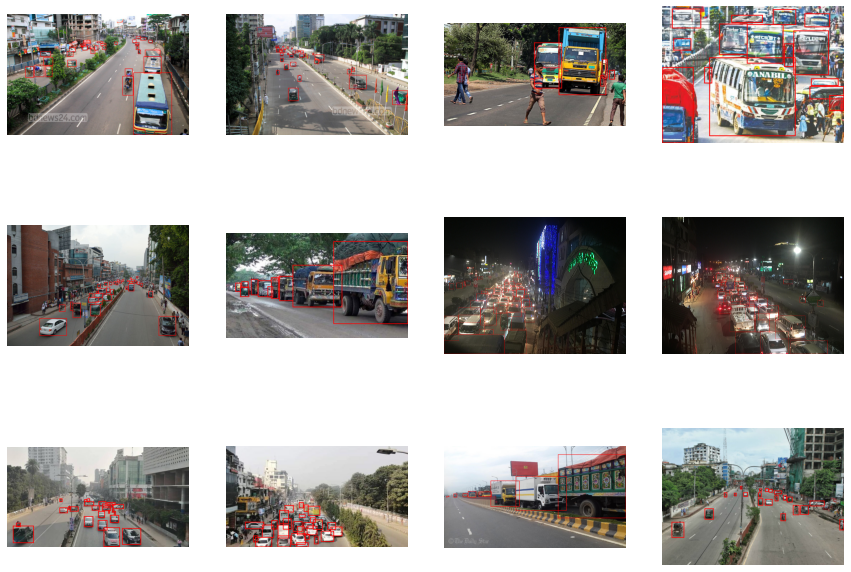

In [ ]:
row = 3; col = 4;
plt.figure(figsize=(15,int(15*row/col)))

for j,img in enumerate(images[0:row*col]):
    
    plt.subplot(row,col,j+1)
    plt.axis('off')
    sample_image_annotated=Image.open(img)
    
    img_bbox = ImageDraw.Draw(sample_image_annotated)
    
    keys=list(dictionary.keys())
    for bbox in dictionary[keys[j]]:
        img_bbox.rectangle(bbox[1:], outline="red",width=3)
        
    plt.imshow(sample_image_annotated)

In [ ]:
xml_df.to_csv('/content/drive/My Drive/Colab_Notebooks/dhaka-ai/train/train_bbox.csv',index=False)

In [ ]:
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf


DATASET_PATH  = img_dir
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 25  
FREEZE_LAYERS = 16  
NUM_EPOCHS    = 1
LEARNING_RATE = 5e-5
DROP_OUT = .5
chkpoint_model_loc = '5'


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation"
                                                  )
class_dictionary = train_batches.class_indices
class_dictionary


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


{}